# Bringing dataset

In [8]:
!mkdir ~p ~/.kaggle
!cp kaggle.json ~/.kaggle/

mkdir: cannot create directory ‘~p’: File exists
mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [9]:
!kaggle datasets download mriffaud/rick-and-morty

Dataset URL: https://www.kaggle.com/datasets/mriffaud/rick-and-morty
License(s): unknown
 99% 1.69G/1.71G [00:11<00:00, 139MB/s]
100% 1.71G/1.71G [00:11<00:00, 158MB/s]


In [10]:
import zipfile

zip_ref = zipfile.ZipFile('/content/rick-and-morty.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()


# Data Preparation


In [11]:
#here we have two options:

#1: we can use keras.utils.image_dataset_from directory to quicky load data
#2 generate dataset in from of csv which consists labels and imagepath, as we need augmentation,we will use this

In [12]:
import os
import pandas as pd
train_folder='/content/rick_and_morty/train'
image_paths=[]
labels=[]

for label in os.listdir(train_folder):
  label_dir=os.path.join(train_folder,label)
  for image in os.listdir(label_dir):
    image_path=os.path.join(label_dir,image)
    image_paths.append(image_path)
    labels.append(label)
data={'Image_path':image_paths,'Label':labels}
df=pd.DataFrame(data)
df.to_csv('/content/rick_and_morty/train.csv',index=False)
print("trained csv ")

trained csv 


In [13]:
df_train=pd.read_csv('/content/rick_and_morty/train.csv')
df_train.head()
df_train['Label'].value_counts()

,count
Label,
Rick,3128
Morty,2620
Jerry,1946
Summer,1237
Beth,482


generating for test dataset


In [14]:
import os
import pandas as pd
test_folder='/content/rick_and_morty/test'
image_paths=[]
labels=[]

for image in os.listdir(test_folder):
    image_path=os.path.join(test_folder,image)
    image_paths.append(image_path)
    labels.append("Unknown")
data={'Image_path':image_paths,'Label':labels}
df=pd.DataFrame(data)
df.to_csv('/content/rick_and_morty/test.csv',index=False)
print("Test csv ")

Test csv 


In [15]:
df_test=pd.read_csv('/content/rick_and_morty/test.csv')
df_test.head()

,Image_path,Label
0,/content/rick_and_morty/test/3_E1_402402.jpg,Unknown
1,/content/rick_and_morty/test/3_E1_154029.jpg,Unknown
2,/content/rick_and_morty/test/3_E1_74574.jpg,Unknown
3,/content/rick_and_morty/test/3_E1_256631.jpg,Unknown
4,/content/rick_and_morty/test/3_E1_131298.jpg,Unknown


# IMAGE AUGMENTATION

In [16]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.preprocessing.image import ImageDataGenerator



In [17]:
from sklearn.model_selection import train_test_split
df=pd.read_csv('/content/rick_and_morty/train.csv')

train_df,val_df=train_test_split(df,test_size=0.2,random_state=42)
num_classes=len(df['Label'].unique())


In [18]:
num_classes

5

In [19]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True)
val_datagen=ImageDataGenerator(rescale=1./255)
batch_size=32
target_size=(224,224)

#we are not increasing val_datagen too much because we need validation data as much as true possible

generating data

In [20]:
train_df.shape #before generating

(7530, 2)

In [21]:

train_generator = train_datagen.flow_from_dataframe(dataframe=train_df,
                                                    x_col='Image_path',
                                                    y_col='Label',
                                                    target_size=target_size,
                                                    batch_size=batch_size,
                                                    class_mode='categorical')

validation_generator = val_datagen.flow_from_dataframe(dataframe=val_df,
                                                        x_col='Image_path',
                                                        y_col='Label',
                                                        target_size=target_size,
                                                        batch_size=batch_size,
                                                        class_mode='categorical')

Found 7530 validated image filenames belonging to 5 classes.
Found 1883 validated image filenames belonging to 5 classes.


# EDA


In [22]:
print(train_df.head())
print(train_df.shape)


                                             Image_path   Label
4335  /content/rick_and_morty/train/Morty/1_E3_29604...   Morty
2455  /content/rick_and_morty/train/Rick/1_E9_616991...    Rick
8978  /content/rick_and_morty/train/Beth/2_E5_429512...    Beth
8847  /content/rick_and_morty/train/Summer/1_E8_4447...  Summer
6718  /content/rick_and_morty/train/Jerry/1_E4_43097...   Jerry
(7530, 2)


In [23]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7530 entries, 4335 to 7270
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Image_path  7530 non-null   object
 1   Label       7530 non-null   object
dtypes: object(2)
memory usage: 176.5+ KB


In [24]:
train_df.describe()

,Image_path,Label
count,7530,7530
unique,7530,5
top,/content/rick_and_morty/train/Jerry/2_E7_77077...,Rick
freq,1,2496


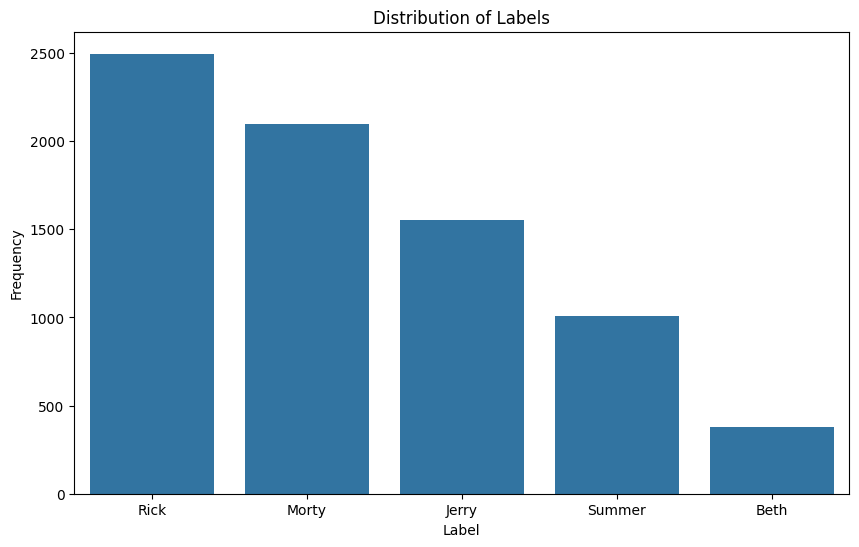

In [25]:
#checking label distribution
plt.figure(figsize=(10, 6))
sns.countplot(data=train_df, x='Label', order=train_df['Label'].value_counts().index)
plt.title('Distribution of Labels')
plt.xlabel('Label')
plt.ylabel('Frequency')
plt.show()



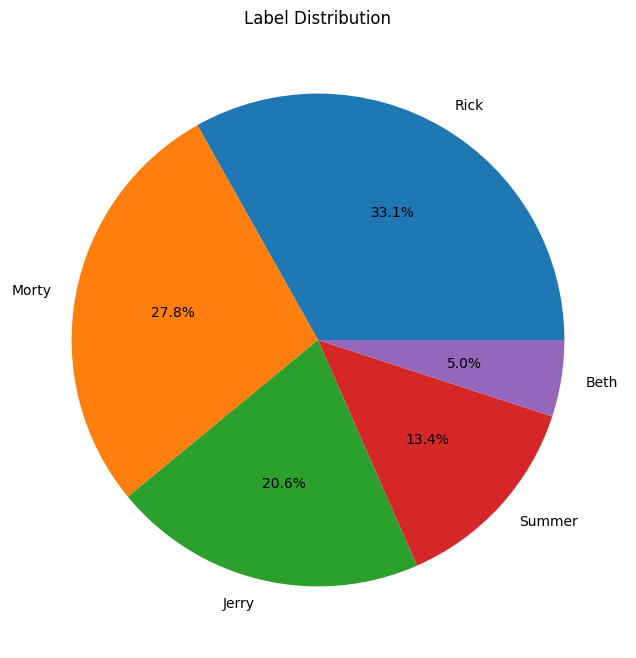

In [26]:
# Pie chart for label distribution
plt.figure(figsize=(8, 8))
train_df['Label'].value_counts().plot(kind='pie', autopct='%1.1f%%')
plt.title('Label Distribution')
plt.ylabel('')  # Hide the y-label
plt.show()

In [27]:
# MODEL BUILDING

In [28]:
#Models used:
#CNN,inceptionv3.mobilenetv3.vgg16


our model

In [29]:
from tensorflow import keras
from keras import Sequential
from keras.layers import Input,Conv2D,MaxPooling2D,Flatten,Dense,Dropout

In [30]:
model=Sequential()

model.add(Input(shape=(224,224,3)))

model.add(Conv2D(64,(5,5),activation='relu'))
model.add(MaxPooling2D((2,2)))

model.add(Conv2D(128,(5,5),activation='relu'))
model.add(MaxPooling2D((2,2)))

model.add(Conv2D(256,(3,3),activation='relu'))
model.add(MaxPooling2D((2,2)))

model.add(Dropout(0.2))
model.add(Flatten())

model.add(Dense(256,activation="relu"))
model.add(Dense(128,activation="relu"))
model.add(Dense(64,activation="relu"))

model.add(Dense(num_classes,activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])




In [31]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_94 (Conv2D)              │ (None, 220, 220, 64)   │         4,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 110, 110, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_95 (Conv2D)              │ (None, 106, 106, 128)  │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 53, 53, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_96 (Conv2D)              │ (None, 51, 51, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 25, 25, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 25, 25, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 160000)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │    40,960,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 41,506,693 (158.34 MB)

 Trainable params: 41,506,693 (158.34 MB)

 Non-trainable params: 0 (0.00 B)

In [37]:
history=model.fit(train_generator,epochs=3,validation_data=validation_generator)

Epoch 1/3
236/236 ━━━━━━━━━━━━━━━━━━━━ 0s 726ms/step - accuracy: 0.7601 - loss: 0.6655

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


236/236 ━━━━━━━━━━━━━━━━━━━━ 200s 844ms/step - accuracy: 0.7603 - loss: 0.6650 - val_accuracy: 0.8332 - val_loss: 0.4814
Epoch 2/3
236/236 ━━━━━━━━━━━━━━━━━━━━ 181s 767ms/step - accuracy: 0.9110 - loss: 0.2775 - val_accuracy: 0.9453 - val_loss: 0.1727
Epoch 3/3
236/236 ━━━━━━━━━━━━━━━━━━━━ 179s 758ms/step - accuracy: 0.9340 - loss: 0.1862 - val_accuracy: 0.9565 - val_loss: 0.1395


Never have my model been so good like this ,ever.When i tried not to use Transfer learning.But Now when i am using it..../


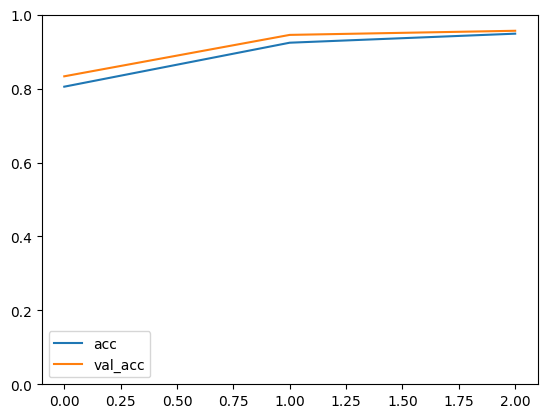

In [38]:


acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
n = len(acc)
plt.ylim(0.0, 1.0)
plt.plot(acc, label='acc')
plt.plot(val_acc, label='val_acc')
plt.legend()

# TRANSFER LEARNING



In [ ]:

from keras.applications import MobileNetV2,InceptionV3,VGG16
from keras import layers, models, optimizers


In [ ]:
#loading models
#list->basemodel,inputshape,modelname
base_models=[
    (InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3)), (299, 299, 3), 'InceptionV3'),
    (MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3)), (224, 224, 3), 'MobileNetV2'),
     (VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3)), (224, 224, 3), 'VGG16')
]

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


# Customizing the Model

In [39]:
from keras import Sequential
from keras.layers import Dense
from keras import optimizers
from keras.layers import Dense,GlobalAveragePooling2D

In [44]:
def create_model(base_model,input_shape,num_classes):
  base_model.trainable=False
  model=Sequential([
      base_model,
      GlobalAveragePooling2D(),
      Dense(512,activation='relu'),
       Dense(256,activation='relu'),
      Dense(num_classes,activation='softmax')


  ])
  return model

In [48]:
def train_and_evaluate(model, train_data, val_data, model_name):
    # Compile the model
    model.compile(optimizer=optimizers.Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

    #training model:
    history = model.fit(train_generator,
                    validation_data=validation_generator,
                    steps_per_epoch=len(train_generator),
                    epochs=5)
    val_accuracy = history.history['val_accuracy'][-1]
    print(f'{model_name} Validation Accuracy: {val_accuracy:.4f}')

    #Plot Training history
    plt.plot(history.history['accuracy'], label='accuracy')
    plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.ylim([0, 1])
    plt.legend(loc='lower right')
    plt.title(f'{model_name} Accuracy')
    plt.show()

    return history




In [49]:
#saving models:
save_dir = '/content/saved_models'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)


Evaluating :  InceptionV3
Epoch 1/5
236/236 ━━━━━━━━━━━━━━━━━━━━ 214s 848ms/step - accuracy: 0.6198 - loss: 1.0589 - val_accuracy: 0.8603 - val_loss: 0.4183
Epoch 2/5
236/236 ━━━━━━━━━━━━━━━━━━━━ 243s 793ms/step - accuracy: 0.8562 - loss: 0.3932 - val_accuracy: 0.8598 - val_loss: 0.3810
Epoch 3/5
236/236 ━━━━━━━━━━━━━━━━━━━━ 211s 894ms/step - accuracy: 0.8975 - loss: 0.2851 - val_accuracy: 0.9299 - val_loss: 0.2142
Epoch 4/5
236/236 ━━━━━━━━━━━━━━━━━━━━ 183s 774ms/step - accuracy: 0.9137 - loss: 0.2402 - val_accuracy: 0.9071 - val_loss: 0.2753
Epoch 5/5
236/236 ━━━━━━━━━━━━━━━━━━━━ 195s 748ms/step - accuracy: 0.9341 - loss: 0.1871 - val_accuracy: 0.8991 - val_loss: 0.2841
InceptionV3 Validation Accuracy: 0.8991


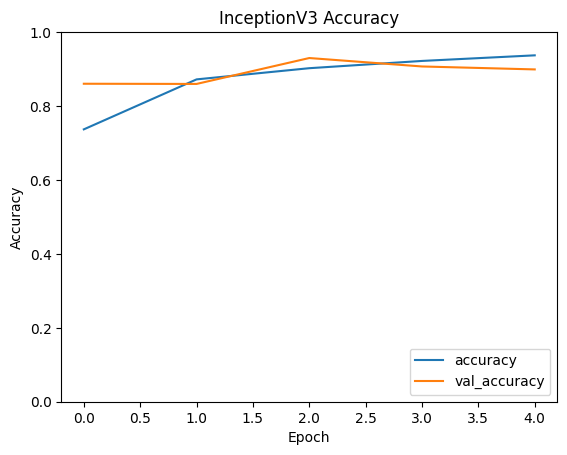

Saved InceptionV3 model to /content/saved_models/InceptionV3_saved.h5
Evaluating :  MobileNetV2
Epoch 1/5
236/236 ━━━━━━━━━━━━━━━━━━━━ 194s 775ms/step - accuracy: 0.7545 - loss: 0.7066 - val_accuracy: 0.9156 - val_loss: 0.2325
Epoch 2/5
236/236 ━━━━━━━━━━━━━━━━━━━━ 192s 758ms/step - accuracy: 0.9328 - loss: 0.1903 - val_accuracy: 0.9453 - val_loss: 0.1586
Epoch 3/5
236/236 ━━━━━━━━━━━━━━━━━━━━ 199s 748ms/step - accuracy: 0.9561 - loss: 0.1269 - val_accuracy: 0.8593 - val_loss: 0.4271
Epoch 4/5
236/236 ━━━━━━━━━━━━━━━━━━━━ 206s 766ms/step - accuracy: 0.9739 - loss: 0.0828 - val_accuracy: 0.9495 - val_loss: 0.1617
Epoch 5/5
236/236 ━━━━━━━━━━━━━━━━━━━━ 175s 741ms/step - accuracy: 0.9753 - loss: 0.0657 - val_accuracy: 0.9649 - val_loss: 0.1131
MobileNetV2 Validation Accuracy: 0.9649


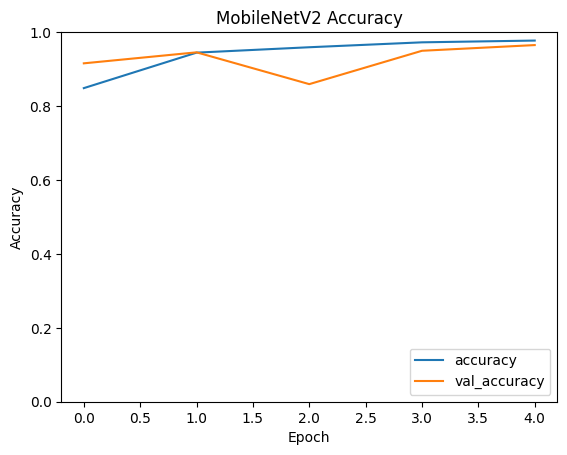

Saved MobileNetV2 model to /content/saved_models/MobileNetV2_saved.h5
Evaluating :  VGG16
Epoch 1/5
236/236 ━━━━━━━━━━━━━━━━━━━━ 220s 862ms/step - accuracy: 0.6076 - loss: 1.0213 - val_accuracy: 0.8502 - val_loss: 0.4355
Epoch 2/5
236/236 ━━━━━━━━━━━━━━━━━━━━ 187s 792ms/step - accuracy: 0.8749 - loss: 0.3576 - val_accuracy: 0.8380 - val_loss: 0.3851
Epoch 3/5
236/236 ━━━━━━━━━━━━━━━━━━━━ 202s 792ms/step - accuracy: 0.9164 - loss: 0.2507 - val_accuracy: 0.9570 - val_loss: 0.1376
Epoch 4/5
236/236 ━━━━━━━━━━━━━━━━━━━━ 186s 789ms/step - accuracy: 0.9385 - loss: 0.1816 - val_accuracy: 0.9087 - val_loss: 0.2713
Epoch 5/5
236/236 ━━━━━━━━━━━━━━━━━━━━ 224s 883ms/step - accuracy: 0.9468 - loss: 0.1496 - val_accuracy: 0.9055 - val_loss: 0.2932
VGG16 Validation Accuracy: 0.9055


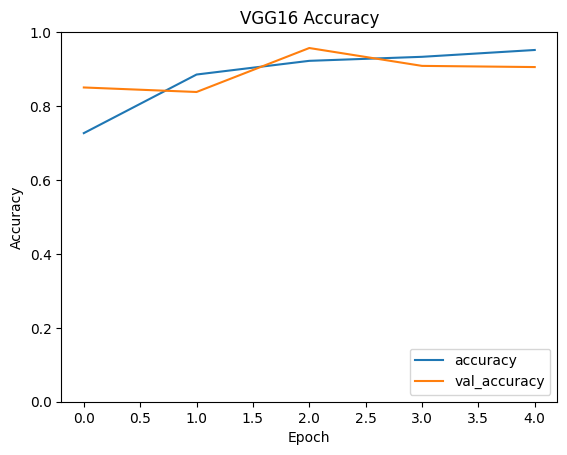

Saved VGG16 model to /content/saved_models/VGG16_saved.h5


In [50]:
histories={}


for base_model,input_shape,model_name in base_models:
  model=create_model(base_model,input_shape,num_classes)
  print("Evaluating : ",model_name)
  history = train_and_evaluate(model, train_generator, validation_generator, model_name)
  histories[model_name] = history
      # Save the model after training
  model.save(os.path.join(save_dir, f'{model_name}_saved.h5'))
  print(f'Saved {model_name} model to {save_dir}/{model_name}_saved.h5')


# TESTING UNSEEN DATA

In [56]:
from keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt

filenames = [
    '/content/rick_and_morty/test/3_E1_237237.jpg',
    '/content/rick_and_morty/test/3_E1_155906.jpg',
    '/content/rick_and_morty/test/3_E1_212838.jpg',
    '/content/rick_and_morty/test/3_E1_253086.jpg',
    '/content/rick_and_morty/test/3_E1_119619.jpg',
    '/content/rick_and_morty/test/3_E1_392183.jpg'
]



def predict_image(filenames, model , model_name):
    classes = ["Beth", "Jerry", "Morty", "Rick" , "Summer"]  # Define your class names
    num_images = len(filenames)

    fig, axes = plt.subplots(1, num_images, figsize=(12, 4))

    for i, filename in enumerate(filenames):
        # if model_name == 'InceptionV3_saved':
        #     img_ = image.load_img(filename, target_size=(299, 299))  # Use target size 299x299 for InceptionV3
        # else:
        img_ = image.load_img(filename, target_size=(224, 224))  # Default target size for other models
        img_array = image.img_to_array(img_)
        img_processed = np.expand_dims(img_array, axis=0)
        img_processed /= 255.

        prediction = model.predict(img_processed)
        index = np.argmax(prediction)

        ax = axes[i] if num_images > 1 else axes
        ax.imshow(img_array)
        ax.set_title(f" Prediction - {classes[index].title()}", size=12, color='red')


    plt.tight_layout()
    plt.show()

Predictions using model: MobileNetV2_saved
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


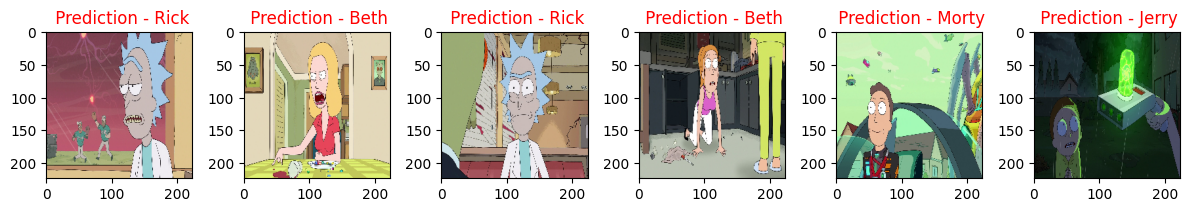

Predictions using model: VGG16_saved
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 583ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


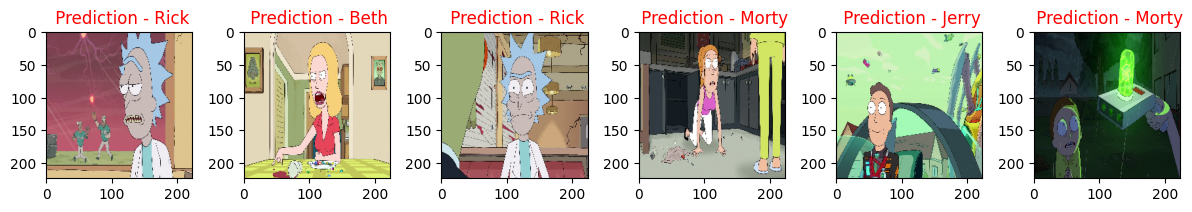

Predictions using model: InceptionV3_saved
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


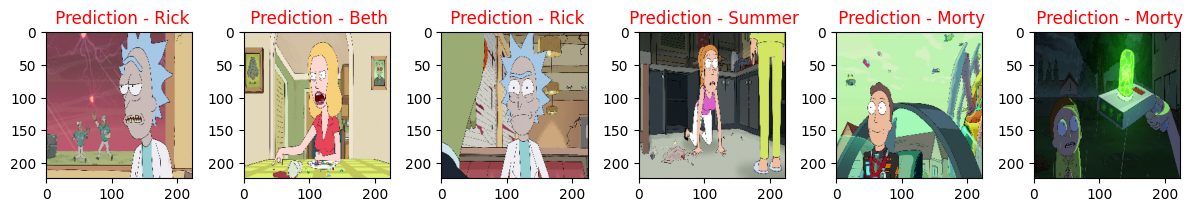

In [57]:
from tensorflow.keras.models import load_model

# Directory containing the saved models
model_dir = '/content/saved_models'

# Iterate over each model file in the directory
for model_file in os.listdir(model_dir):
    if model_file.endswith('.h5'):
        # Load the model
        model_path = os.path.join(model_dir, model_file)
        model = load_model(model_path)

        # Determine the model name
        model_name = model_file.split('.')[0]

        # Predict and plot images for each model
        print(f"Predictions using model: {model_name}")
        predict_image(filenames, model, model_name)